In [1]:
from IPython.display import HTML

HTML('''
<style>
    .container {
        width: 100% !important;
    }
</style>
''')

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import ipywidgets as widgets
from IPython.display import display

# Load the combined JSON file with all snapshots
with open('graphs/tictactoe.json', 'r') as f:
    graph_data = json.load(f)

# Extract the list of snapshots from the JSON
graph_snapshots = graph_data['graphs']

# Function to plot a specific snapshot based on the selected index
def plot_dag_snapshot(snapshot_index):
    snapshot = graph_snapshots[snapshot_index]

    G = nx.DiGraph()

    # Add nodes
    for node in snapshot['nodes']:
        G.add_node(
            node['index'], 
            N=node['N'], 
            Q=node['Q'], 
            state=node['state']
        )

    # Add edges
    for edge in snapshot['edges']:
        G.add_edge(
            edge['from'], 
            edge['to'], 
            E=edge['E'], 
            action=edge['action'], 
            index=edge['index']
        )

    # Use graphviz_layout for hierarchical placement
    pos = graphviz_layout(G, prog="dot")

    # Define node labels
    node_labels = {node: f"{data['state']}\nN: {data['N']}\nQ: {[f'{float(q):.2f}' for q in data['Q']][0]}" for node, data in G.nodes(data=True)}

    # Define edge labels (showing E and action)
    edge_labels = {(u, v): f"A: {data['action']}, E: {data['E']}" for u, v, data in G.edges(data=True)}

    # Clear the current plot
    plt.figure(figsize=(20, 10))
    
    # Draw the graph for this snapshot
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color="lightblue", font_size=10)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="black")

    # Draw edge labels 
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.7, font_size=8)

    # Set the plot title to indicate which snapshot is being displayed
    plt.title(f"DAG Snapshot {snapshot_index + 1}")
    plt.show()

# Create an interactive slider to select the snapshot index
snapshot_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(graph_snapshots) - 1,
    step=1,
    description='Snapshot:',
    continuous_update=False
)

# Display the plot for the selected snapshot whenever the slider value changes
widgets.interactive(lambda snapshot_index: plot_dag_snapshot(snapshot_index), snapshot_index=snapshot_slider)



In [23]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import ipywidgets as widgets
from IPython.display import display

# Load the combined JSON file with all snapshots
with open('graphs/tictactoe.json', 'r') as f:
    graph_data = json.load(f)

# Extract the list of snapshots from the JSON
graph_snapshots = graph_data['graphs']

# Function to plot a specific snapshot based on the selected index
def plot_dag_snapshot(snapshot_index):
    # Retrieve the current snapshot and the previous one (if exists)
    snapshot = graph_snapshots[snapshot_index]
    previous_snapshot = graph_snapshots[snapshot_index - 1] if snapshot_index > 0 else None

    # Initialize the directed graph
    G = nx.DiGraph()

    # Create sets for changed nodes and edges
    new_nodes = set()
    new_edges = set()
    changed_nodes = set()
    changed_edges = set()

    # Add nodes, tracking changes
    for node in snapshot['nodes']:
        node_id = node['index']
        G.add_node(node_id, N=node['N'], Q=node['Q'], state=node['state'])

        # Check if the node is new or has changed if a previous snapshot exists
        if previous_snapshot:
            prev_node = next((n for n in previous_snapshot['nodes'] if n['index'] == node_id), None)
            if not prev_node:
                new_nodes.add(node_id)  # New node
            elif node['N'] != prev_node['N'] or node['Q'] != prev_node['Q']:
                changed_nodes.add(node_id)  # Changed node
        else:
            new_nodes.add(node_id)  # No previous snapshot, mark as new

    # Add edges, tracking changes
    for edge in snapshot['edges']:
        edge_from = edge['from']
        edge_to = edge['to']
        G.add_edge(edge_from, edge_to, E=edge['E'], action=edge['action'], index=edge['index'])

        # Check if the edge is new or if any attribute has changed
        if previous_snapshot:
            prev_edge = next((e for e in previous_snapshot['edges'] if e['index'] == edge['index']), None)
            if not prev_edge:
                new_edges.add((edge_from, edge_to))  # New edge
            elif edge['E'] != prev_edge['E'] or edge['action'] != prev_edge['action']:
                print(f"{edge['index']} edge E: {edge['E']}, prev_edge E: {prev_edge['E']}; edge A: {edge['action']}, prev_edge A: {prev_edge['action']}")
                changed_edges.add((edge_from, edge_to))  # Edge label has changed
        else:
            new_edges.add((edge_from, edge_to))  # No previous snapshot, mark as new

    # Use graphviz_layout for hierarchical placement
    pos = graphviz_layout(G, prog="dot")

    # Define node labels, coloring new or changed nodes in red
    node_labels = {}
    for node, data in G.nodes(data=True):
        label = f"({node})\n{data['state']}\nN: {data['N']}\nQ: {[f'{float(q):.2f}' for q in data['Q']][0]}"
        color = "red" if node in new_nodes or node in changed_nodes else "black"
        node_labels[node] = (label, color)

    # Define edge labels, coloring new or changed edges in red
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        label = f"({data['index']})\nA: {data['action']}, E: {data['E']}"
        color = "red" if (u, v) in new_edges or (u, v) in changed_edges else "black"
        edge_labels[(u, v)] = (label, color)

    # Clear the current plot
    plt.figure(figsize=(20, 10))

    # Draw nodes and labels, applying color to changed/new nodes
    nx.draw(
        G, pos, with_labels=False, node_size=3000, node_color="lightblue", font_size=10
    )
    for node, (label, color) in node_labels.items():
        nx.draw_networkx_labels(G, pos, labels={node: label}, font_size=10, font_color=color)

    # Draw edges and edge labels, applying color to new or changed edges
    for (u, v), (label, color) in edge_labels.items():
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: v[0] for k, v in edge_labels.items()}, label_pos=0.6, font_size=8)

    # Set the plot title to indicate which snapshot is being displayed
    plt.title(f"DAG Snapshot {snapshot_index + 1}")
    plt.show()
    return G

# Create an interactive slider to select the snapshot index
snapshot_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(graph_snapshots) - 1,
    step=1,
    description='Snapshot:',
    continuous_update=False
)

# Display the plot for the selected snapshot whenever the slider value changes
widgets.interactive(lambda snapshot_index: plot_dag_snapshot(snapshot_index), snapshot_index=snapshot_slider)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Snapshot:', max=99), Output()),…

0 edge E: 4, prev_edge E: 3; edge A: 3, prev_edge A: 3


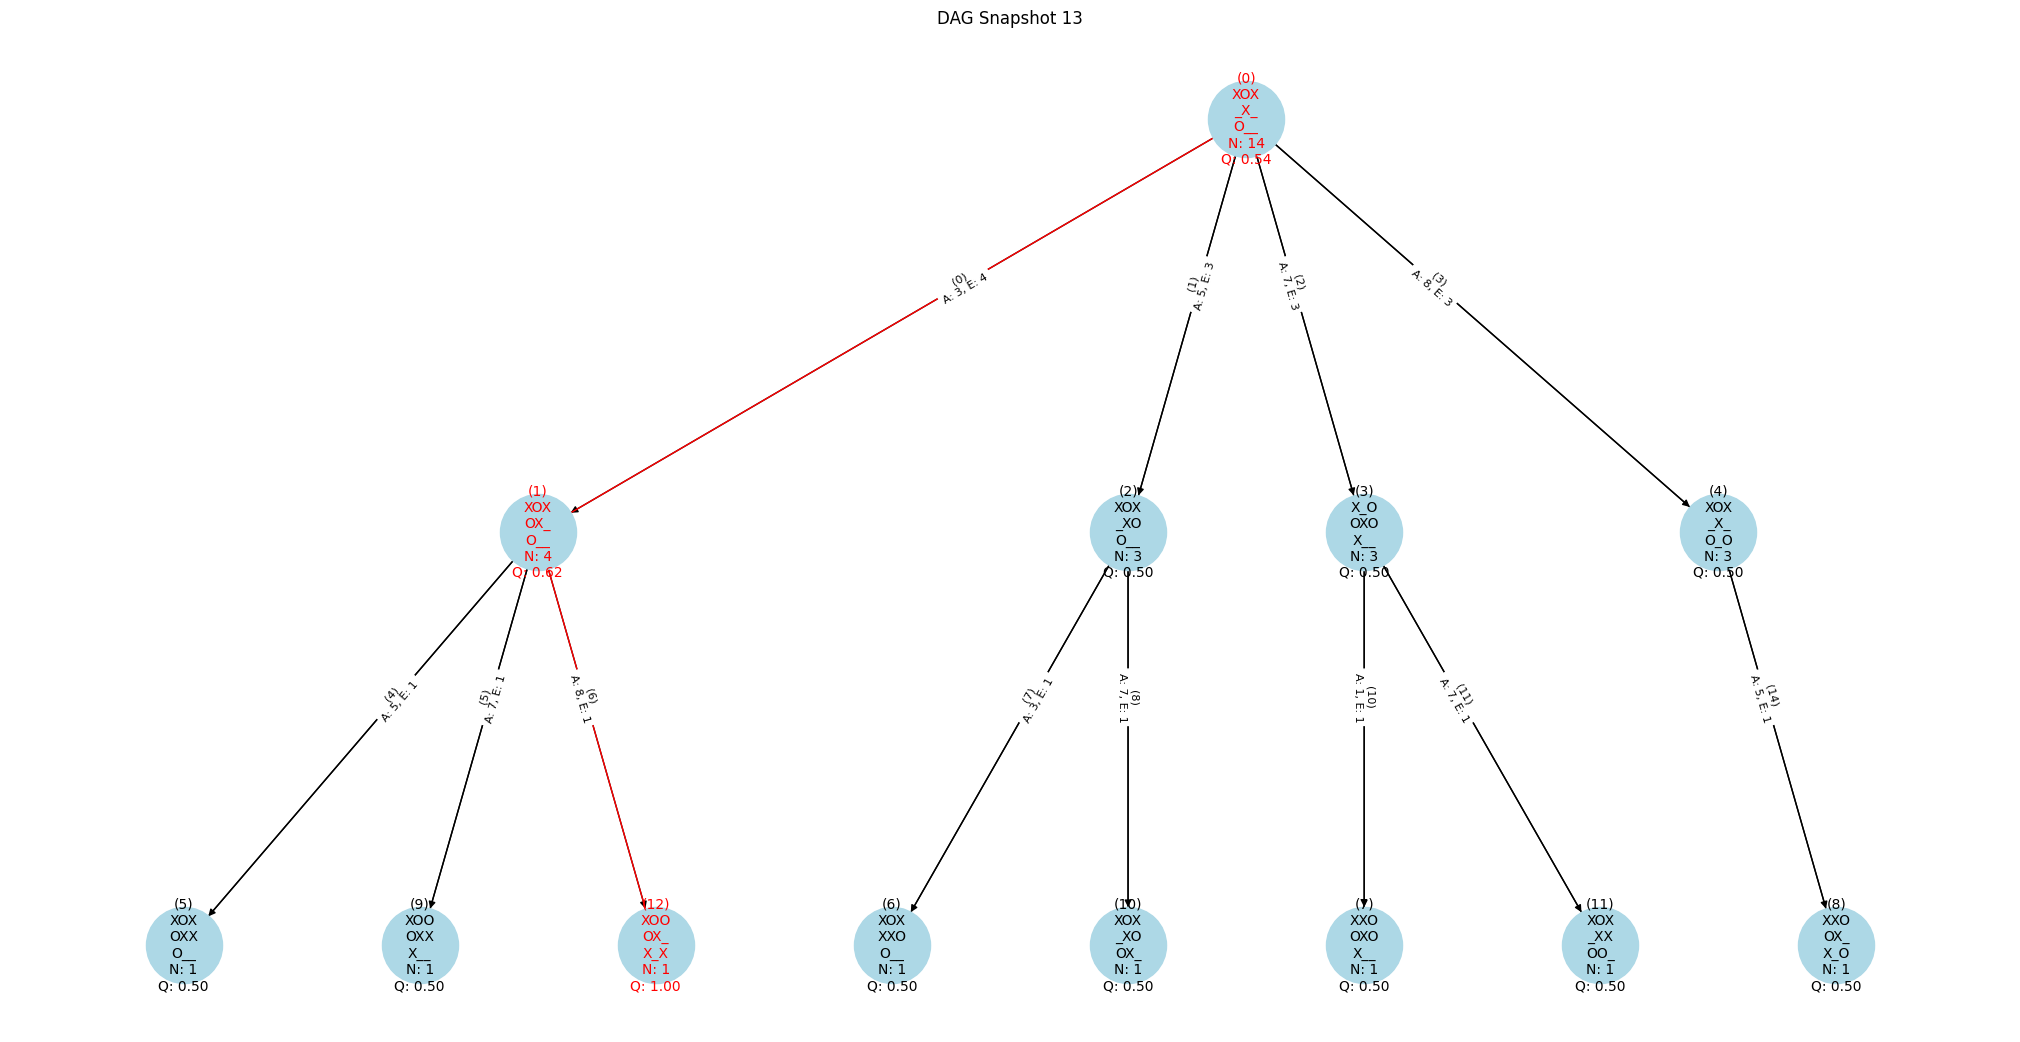

In [24]:
G = plot_dag_snapshot(12)

In [19]:
graph_snapshots[11]

{'nodes': [{'index': 0, 'N': 13, 'Q': [0.5, 0.5], 'state': 'XOX\n_X_\nO__'},
  {'index': 1, 'N': 3, 'Q': [0.5, 0.5], 'state': 'XOX\nOX_\nO__'},
  {'index': 2, 'N': 3, 'Q': [0.5, 0.5], 'state': 'XOX\n_XO\nO__'},
  {'index': 3, 'N': 3, 'Q': [0.5, 0.5], 'state': 'X_O\nOXO\nX__'},
  {'index': 4, 'N': 3, 'Q': [0.5, 0.5], 'state': 'XOX\n_X_\nO_O'},
  {'index': 5, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOX\nOXX\nO__'},
  {'index': 6, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOX\nXXO\nO__'},
  {'index': 7, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XXO\nOXO\nX__'},
  {'index': 8, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XXO\nOX_\nX_O'},
  {'index': 9, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOO\nOXX\nX__'},
  {'index': 10, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOX\n_XO\nOX_'},
  {'index': 11, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOX\n_XX\nOO_'}],
 'edges': [{'index': 0, 'from': 0, 'to': 1, 'E': 3, 'action': 3},
  {'index': 1, 'from': 0, 'to': 2, 'E': 3, 'action': 5},
  {'index': 2, 'from': 0, 'to': 3, 'E': 3, 'action': 7},
  {

In [18]:
graph_snapshots[12]

{'nodes': [{'index': 0,
   'N': 14,
   'Q': [0.535714, 0.464286],
   'state': 'XOX\n_X_\nO__'},
  {'index': 1, 'N': 4, 'Q': [0.625, 0.375], 'state': 'XOX\nOX_\nO__'},
  {'index': 2, 'N': 3, 'Q': [0.5, 0.5], 'state': 'XOX\n_XO\nO__'},
  {'index': 3, 'N': 3, 'Q': [0.5, 0.5], 'state': 'X_O\nOXO\nX__'},
  {'index': 4, 'N': 3, 'Q': [0.5, 0.5], 'state': 'XOX\n_X_\nO_O'},
  {'index': 5, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOX\nOXX\nO__'},
  {'index': 6, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOX\nXXO\nO__'},
  {'index': 7, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XXO\nOXO\nX__'},
  {'index': 8, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XXO\nOX_\nX_O'},
  {'index': 9, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOO\nOXX\nX__'},
  {'index': 10, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOX\n_XO\nOX_'},
  {'index': 11, 'N': 1, 'Q': [0.5, 0.5], 'state': 'XOX\n_XX\nOO_'},
  {'index': 12, 'N': 1, 'Q': [1, 0], 'state': 'XOO\nOX_\nX_X'}],
 'edges': [{'index': 0, 'from': 0, 'to': 1, 'E': 4, 'action': 3},
  {'index': 1, 'from': 0, 'to'

In [21]:
prev_edge = next((e for e in graph_snapshots[11]['edges'] if e['from'] == 4 and e['to'] == 8), None)

In [22]:
prev_edge

{'index': 13, 'from': 4, 'to': 8, 'E': 1, 'action': 3}